In [ ]:
# The installation of pypfopt is failing, so we will remove it from the installation command.
!pip install matplotlib numpy pandas statsmodels yfinance cvxopt joblib pandas_datareader PyPortfolioOpt

# 1. Data Collection and Preprocessing

In [17]:
import yfinance as yf
import pandas as pd
import os

# Define the list of ETFs
etfs = ['SPY', 'XLK', 'XLF', 'XLV', 'XLE', 'XLY', 
        'XLP', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC', 
        'SPYD', 'SPYI']

# etfs = ['SPY', 'QQQ', 'QLC', 'IWM', 'DAX', 
#            'XLK', 'XLF', 'XLV', 'XLE', 'XLY', 'XLP', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC', 
#            'TQQQ', 'UPRO', 'TECL', 'TECS', 'FAS', 'FAZ', 'ERX', 'ERY', 'SOXL', 'SPXS', 
#            'VIX', 'UVXY',
#            'SPYD', 'SPYI', 'O', 'JEPI',
#            'TSLA', 'NVDA', 'AMD', 'INTC', 'NVDL', 'TSLL']

# Create a directory to store the data
os.makedirs('index_data', exist_ok=True)
os.makedirs('index_data/1d', exist_ok=True)
os.makedirs('index_data/1wk', exist_ok=True)
os.makedirs('index_data/1mo', exist_ok=True)

# Function to fetch and save data for a given ETF
def fetch_and_save_data(etf, interval, period):
    try:
        data = yf.download(etf, interval=interval, period=period, auto_adjust=True)
        if not data.empty:
            data.to_csv(f'index_data/{interval}/{etf}_{interval}.csv')
        else:
            print(f"No data found for {etf} with interval {interval} and period {period}")
    except Exception as e:
        print(f"Error fetching data for {etf}: {e}")

# Fetch data for each ETF
for etf in etfs:
    fetch_and_save_data(etf, '1d', 'max')  # Daily data
    fetch_and_save_data(etf, '1wk', 'max')  # Weekly data
    fetch_and_save_data(etf, '1mo', 'max')  # Monthly data

# Data Cleaning and Transformation
def clean_and_transform_data(etf, interval):
    file_path = f'index_data/{interval}/{etf}_{interval}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        # Handle missing data
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        
        # Save cleaned data
        df.to_csv(file_path)
    else:
        print(f"File not found: {file_path}")

# Clean and transform data for each ETF
for etf in etfs:
    clean_and_transform_data(etf, '1d')
    clean_and_transform_data(etf, '1wk')
    clean_and_transform_data(etf, '1mo')

# Data Enrichment
def adjust_for_corporate_actions(etf, interval):
    file_path = f'index_data/{interval}/{etf}_{interval}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        # Adjust for corporate actions (already done by yfinance with auto_adjust=True)
        # Placeholder for additional adjustments if needed
        
        # Save adjusted data
        df.to_csv(file_path)
    else:
        print(f"File not found: {file_path}")

# Adjust data for corporate actions for each ETF
for etf in etfs:
    adjust_for_corporate_actions(etf, '1d')
    adjust_for_corporate_actions(etf, '1wk')
    adjust_for_corporate_actions(etf, '1mo')

# Feature Scaling (if required)
def feature_scaling(etf, interval):
    file_path = f'index_data/{interval}/{etf}_{interval}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        # Normalize or standardize data
        df_scaled = (df - df.mean()) / df.std()
        
        # Save scaled data
        df_scaled.to_csv(f'index_data/{interval}/{etf}_{interval}_scaled.csv')
    else:
        print(f"File not found: {file_path}")

# Apply feature scaling for each ETF (optional, based on analysis needs)
for etf in etfs:
    feature_scaling(etf, '1d')
    feature_scaling(etf, '1wk')
    feature_scaling(etf, '1mo')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

KeyboardInterrupt: 

# 2. Portfolio Optimization and Black-Litterman Model

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the ETFs
etfs = ['SPY', 'XLK', 'XLF', 'XLV', 'XLE', 'XLY', 
        'XLP', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC', 
        'SPYD', 'SPYI']

# Fetch market caps
market_caps = []
for etf in etfs:
    try:
        ticker = yf.Ticker(etf)
        info = ticker.info
        market_cap = info.get('marketCap', None)

        # Fallback to totalAssets or netAssets if marketCap is unavailable
        if market_cap is None:
            market_cap = info.get('totalAssets', None)
            if market_cap is None:
                market_cap = info.get('netAssets', None)

        if market_cap is None:
            print(f"Market cap or assets data not found for {etf}")
            market_caps.append(0.0)  # Add 0.0 if data is unavailable
        else:
            market_cap_billion = market_cap / 1e9  # Convert to billions
            market_caps.append(market_cap_billion)

    except Exception as e:
        print(f"Error fetching data for {etf}: {e}")
        market_caps.append(0.0)  # Append 0.0 in case of error

# Convert to numpy array
market_caps = np.array(market_caps)

# Verify the length of market_caps matches the number of ETFs
assert len(market_caps) == len(etfs), "Market caps array length must match the number of ETFs."

# Print the market caps
df = pd.DataFrame({'ETF': etfs, 'Market Cap (Billions)': market_caps})
print(df)


     ETF  Market Cap (Billions)
0    SPY             566.341992
1    XLK              69.365989
2    XLF              45.922791
3    XLV              42.485006
4    XLE              37.467464
5    XLY              18.883990
6    XLP              17.136042
7    XLI              19.880589
8    XLU              17.312971
9    XLB               5.640778
10  XLRE               7.663383
11   XLC              18.224900
12  SPYD               6.615171
13  SPYI               1.843319


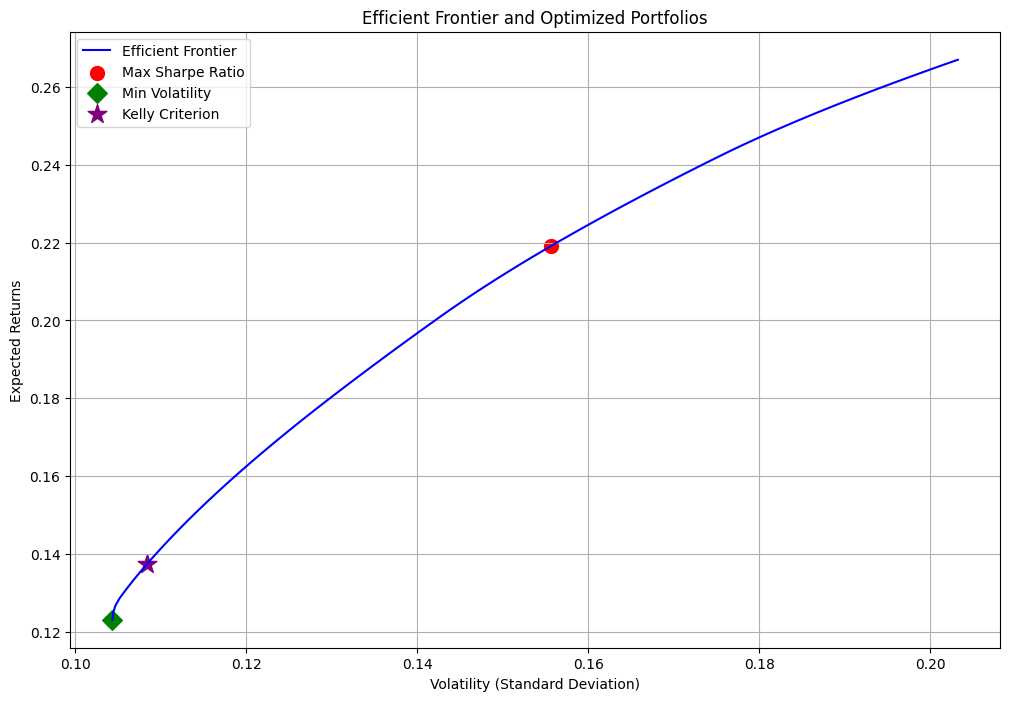

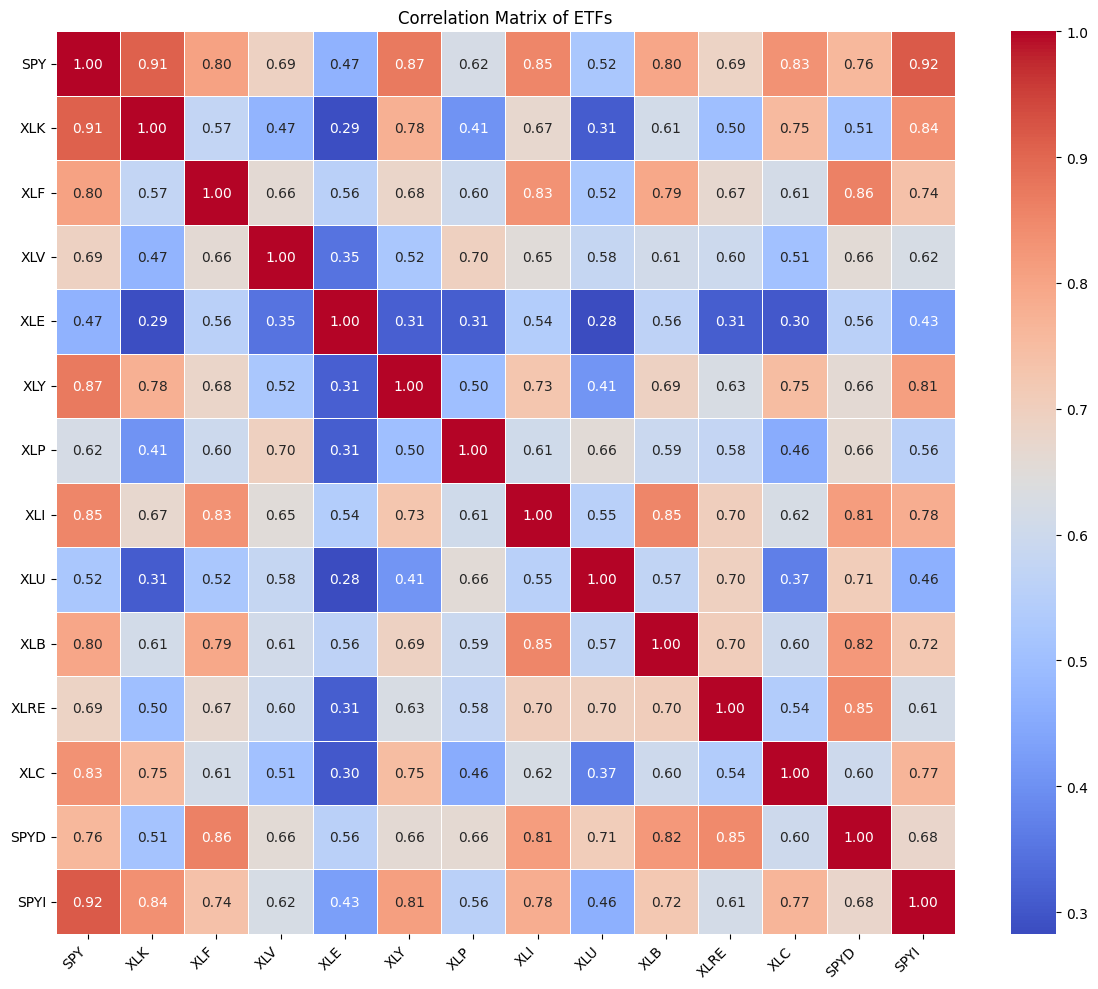

Max Sharpe Ratio Performance:
  Expected Return: 21.91%
  Volatility: 15.56%
  Sharpe Ratio: 1.28

Min Volatility Performance:
  Expected Return: 12.30%
  Volatility: 10.43%
  Sharpe Ratio: 0.99

Kelly Criterion Performance:
  Expected Return: 13.72%
  Volatility: 10.83%
  Sharpe Ratio: 1.27

Max Sharpe Ratio Weights:
  SPY: 0.00%
  XLK: 8.86%
  XLF: 0.00%
  XLV: 19.24%
  XLE: 0.00%
  XLY: 0.00%
  XLP: 0.00%
  XLI: 31.67%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 40.23%
  SPYD: 0.00%
  SPYI: 0.00%


Min Volatility Weights:
  SPY: 0.00%
  XLK: 0.00%
  XLF: 0.00%
  XLV: 15.59%
  XLE: 1.01%
  XLY: 0.00%
  XLP: 37.67%
  XLI: 0.00%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 0.00%
  SPYD: 0.00%
  SPYI: 45.73%


Kelly Criterion Weights:
  SPY: 0.00%
  XLK: 0.00%
  XLF: 0.00%
  XLV: 26.28%
  XLE: 0.00%
  XLY: 0.00%
  XLP: 19.34%
  XLI: 1.54%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 5.00%
  SPYD: 0.00%
  SPYI: 47.84%


                   SPY         XLK        XLF         XLV    

In [20]:

import numpy as np
import pandas as pd
from pypfopt import risk_models, EfficientFrontier, expected_returns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns  # Added for better visualization of correlation matrix

# # Define the ETFs
# etfs = ['SPY', 'XLK', 'XLF', 'XLV', 'XLE', 'XLY', 
#         'XLP', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC', 
#         'SPYD', 'SPYI']
# # etfs = ['SPY', 'XLK', 'XLF', 'XLV', 'XLE', 'XLY', 'XLP', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC', 'SPYD', 'SPYI', 'QQQ', 'TQQQ', 'SOXL', 'SPXS', 'UVXY', 'VIX']
# # need to update other parts of the code if you expand this list...

# # Define the market caps for each ETF (Example values in billions)
# # **IMPORTANT:** Replace these example values with actual market caps
# market_caps = np.array([
#     4000,  # SPY
#     2000,  # XLK
#     1500,  # XLF
#     1000,  # XLV
#     800,   # XLE
#     600,   # XLY
#     500,   # XLP
#     700,   # XLI
#     300,   # XLU
#     400,   # XLB
#     350,   # XLRE
#     450,   # XLC
#     250,   # SPYD
#     275    # SPYI
# ])  # Ensure this array has 14 elements matching the ETFs list

# # Verify the length of market_caps matches the number of ETFs
# assert len(market_caps) == len(etfs), "Market caps array length must match the number of ETFs."
# Load historical price data and calculate returns
def load_price_data(etfs, interval):
    price_data = {}
    for etf in etfs:
        file_path = f'index_data/{interval}/{etf}_{interval}.csv'
        try:
            df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
            price_data[etf] = df['Close']
        except FileNotFoundError:
            print(f"File not found for {etf} at {file_path}. Ensure the file exists.")
            price_data[etf] = np.nan  # Assign NaN if file not found
    price_df = pd.DataFrame(price_data).dropna()  # Drop dates with missing data
    return price_df

# Calculate expected returns and covariance matrix
def calculate_returns_and_covariance(price_data):
    returns = price_data.pct_change().dropna()
    expected_returns_vals = returns.mean() * 252  # Annualize returns
    covariance_matrix = returns.cov() * 252  # Annualize covariance
    return expected_returns_vals, covariance_matrix, returns

# Load data and compute returns and covariance
price_data = load_price_data(etfs, '1d')
expected_returns_vals, covariance_matrix, returns = calculate_returns_and_covariance(price_data)

# Market equilibrium weights based on market caps
market_weights = market_caps / market_caps.sum()

# ============================
# Portfolio Optimization
# ============================

# Portfolio optimization for maximum Sharpe Ratio
ef_sharpe = EfficientFrontier(expected_returns_vals, covariance_matrix)
try:
    sharpe_weights = ef_sharpe.max_sharpe()
    cleaned_sharpe_weights = ef_sharpe.clean_weights()
    sharpe_performance = ef_sharpe.portfolio_performance()
except Exception as e:
    print(f"Error in Max Sharpe Ratio optimization: {e}")
    sharpe_weights = {}
    cleaned_sharpe_weights = {}
    sharpe_performance = {}

# Portfolio optimization for minimum volatility
ef_min_vol = EfficientFrontier(expected_returns_vals, covariance_matrix)
try:
    min_vol_weights = ef_min_vol.min_volatility()
    cleaned_min_vol_weights = ef_min_vol.clean_weights()
    min_vol_performance = ef_min_vol.portfolio_performance()
except Exception as e:
    print(f"Error in Min Volatility optimization: {e}")
    min_vol_weights = {}
    cleaned_min_vol_weights = {}
    min_vol_performance = {}

# Portfolio optimization using Kelly Criterion (Maximize expected log return)
def kelly_criterion(weights, expected_returns, covariance_matrix):
    # Prevent division by zero
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    if portfolio_variance == 0:
        return 1e10
    portfolio_return = np.dot(weights, expected_returns)
    return -portfolio_return / portfolio_variance  # Negative for minimization

# Initial guess
num_assets = len(etfs)
initial_weights = num_assets * [1. / num_assets,]

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0,1) for asset in range(num_assets))

# Optimization
kelly_result = minimize(
    kelly_criterion, 
    initial_weights, 
    args=(expected_returns_vals.values, covariance_matrix.values), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

if kelly_result.success:
    kelly_weights = kelly_result.x
    # Compute performance metrics
    kelly_return = np.dot(kelly_weights, expected_returns_vals.values)
    kelly_volatility = np.sqrt(np.dot(kelly_weights.T, np.dot(covariance_matrix.values, kelly_weights)))
    kelly_sharpe = kelly_return / kelly_volatility
    kelly_performance = (kelly_return, kelly_volatility, kelly_sharpe)
    # Clean weights for display
    cleaned_kelly_weights = {etf: weight for etf, weight in zip(etfs, kelly_weights)}
else:
    print("Kelly Criterion optimization failed.")
    kelly_weights = {}
    cleaned_kelly_weights = {}
    kelly_performance = {}

# ============================
# Efficient Frontier Plotting
# ============================

def get_efficient_frontier(expected_returns, covariance_matrix, num_points=100):
    min_ret = expected_returns.min()
    max_ret = expected_returns.max()
    target_returns = np.linspace(min_ret, max_ret, num_points)
    risks = []
    rets = []
    for ret in target_returns:
        ef = EfficientFrontier(expected_returns, covariance_matrix)
        try:
            ef.efficient_return(ret)
            performance = ef.portfolio_performance()
            risks.append(performance[1])
            rets.append(performance[0])
        except:
            continue
    return risks, rets

# Get efficient frontier points
frontier_risks, frontier_rets = get_efficient_frontier(expected_returns_vals, covariance_matrix)

# Plot the efficient frontier and optimized portfolios
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(frontier_risks, frontier_rets, label='Efficient Frontier', color='blue')

# Plot optimized portfolios
if sharpe_performance:
    ax.scatter(sharpe_performance[1], sharpe_performance[0], marker='o', color='red', s=100, label='Max Sharpe Ratio')
if min_vol_performance:
    ax.scatter(min_vol_performance[1], min_vol_performance[0], marker='D', color='green', s=100, label='Min Volatility')
if kelly_performance:
    ax.scatter(kelly_performance[1], kelly_performance[0], marker='*', color='purple', s=200, label='Kelly Criterion')

plt.title('Efficient Frontier and Optimized Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.legend()
plt.grid(True)
plt.show()

# ============================
# Correlation Matrix Visualization
# ============================

def plot_correlation_matrix(returns, etfs):
    correlation_matrix = returns.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                xticklabels=etfs, yticklabels=etfs, linewidths=0.5)
    plt.title('Correlation Matrix of ETFs')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot the correlation matrix
plot_correlation_matrix(returns, etfs)

# ============================
# Print Performance Metrics
# ============================

def print_performance(name, performance):
    if performance:
        print(f"{name} Performance:")
        print(f"  Expected Return: {performance[0]:.2%}")
        print(f"  Volatility: {performance[1]:.2%}")
        print(f"  Sharpe Ratio: {performance[2]:.2f}\n")
    else:
        print(f"{name} Performance: Not Available\n")

print_performance("Max Sharpe Ratio", sharpe_performance)
print_performance("Min Volatility", min_vol_performance)
print_performance("Kelly Criterion", kelly_performance)

# ============================
# Optional: Display Portfolio Weights
# ============================

def display_weights(name, weights):
    if weights:
        print(f"{name} Weights:")
        for etf, weight in weights.items():
            print(f"  {etf}: {weight:.2%}")
        print("\n")
    else:
        print(f"{name} Weights: Not Available\n")

display_weights("Max Sharpe Ratio", cleaned_sharpe_weights)
display_weights("Min Volatility", cleaned_min_vol_weights)
display_weights("Kelly Criterion", cleaned_kelly_weights)

# ============================
# Data Inspection (Optional)
# ============================

# Uncomment the following lines if you want to inspect the data
print(price_data.head())
print(expected_returns_vals)
print(covariance_matrix)
print(np.isnan(expected_returns_vals).any())  # Should return False
print(np.isnan(covariance_matrix).any())  # Should return False


# 3. Visualizations for Correlation and Covariance

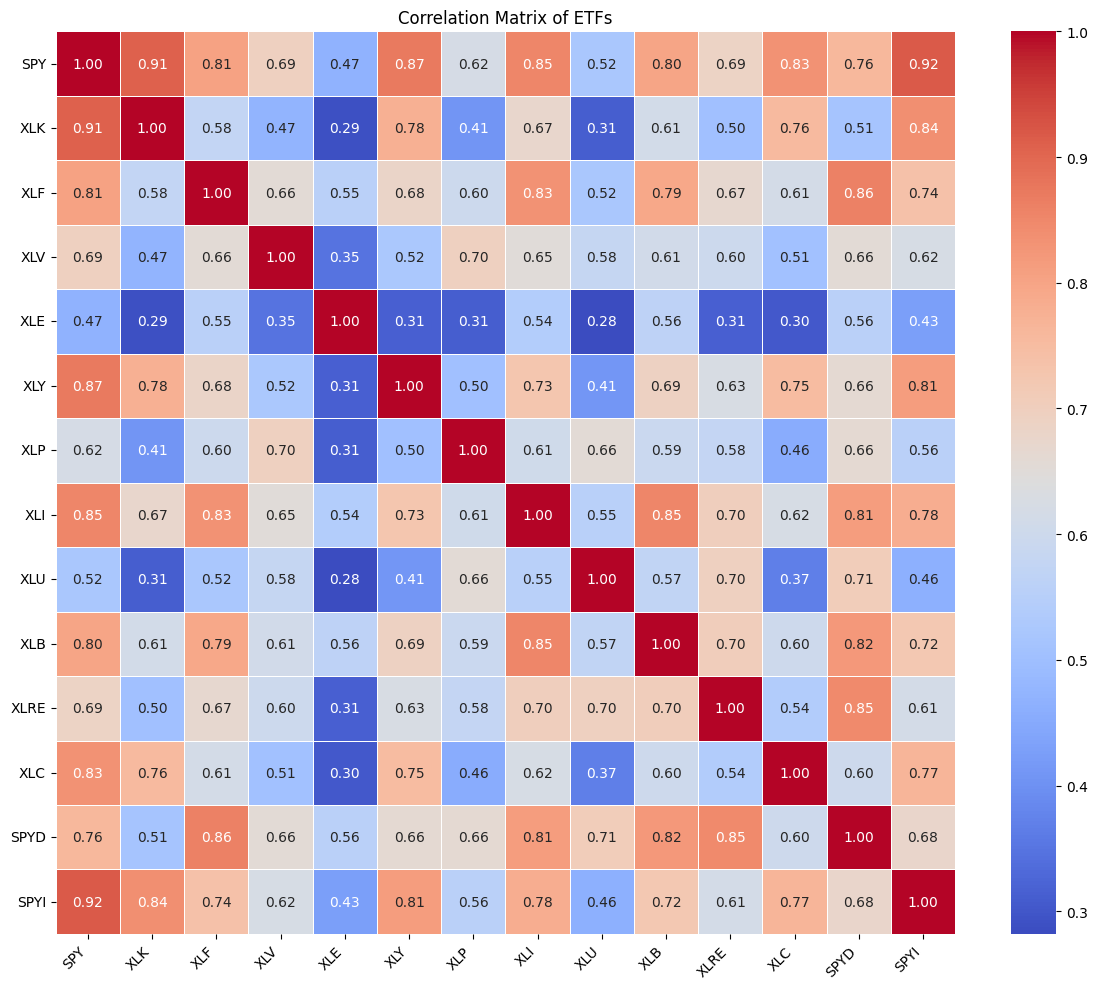

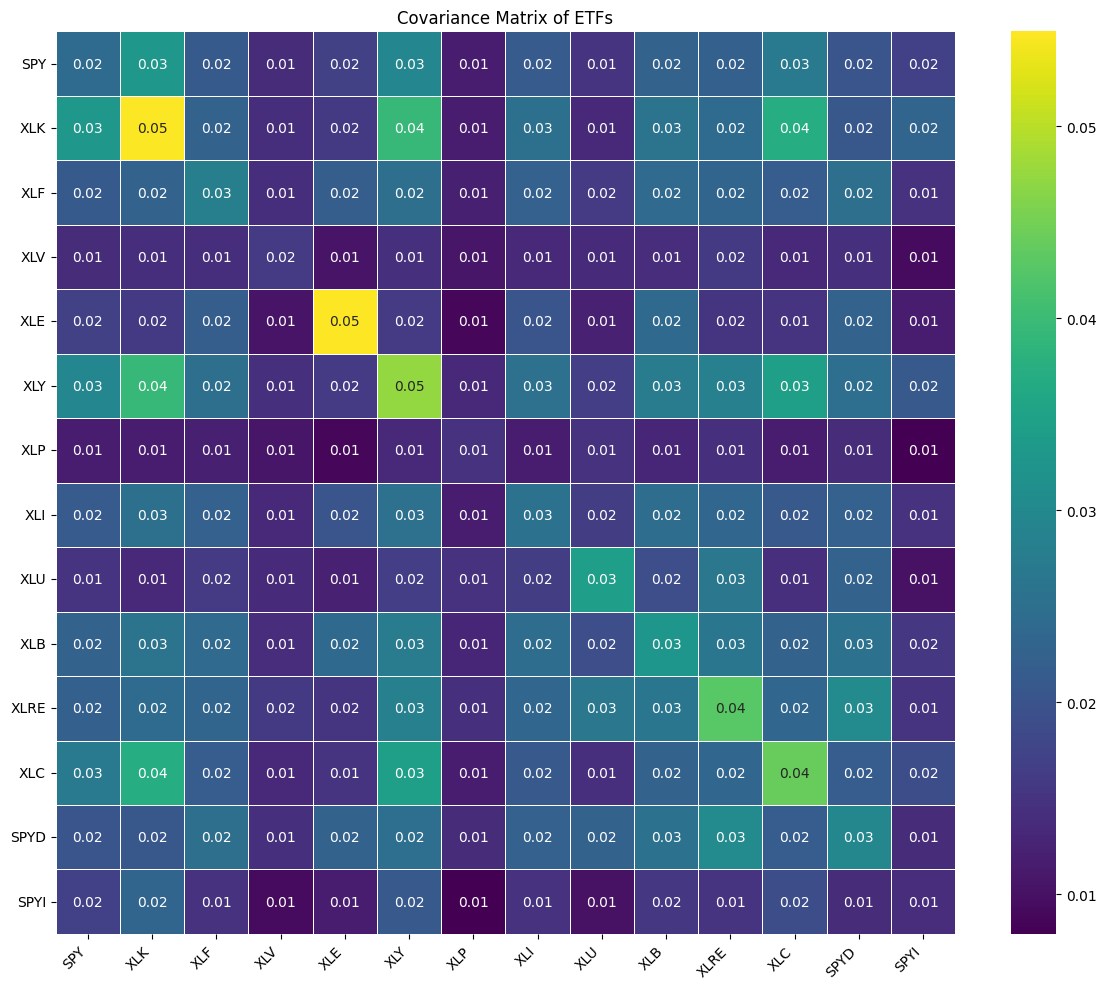

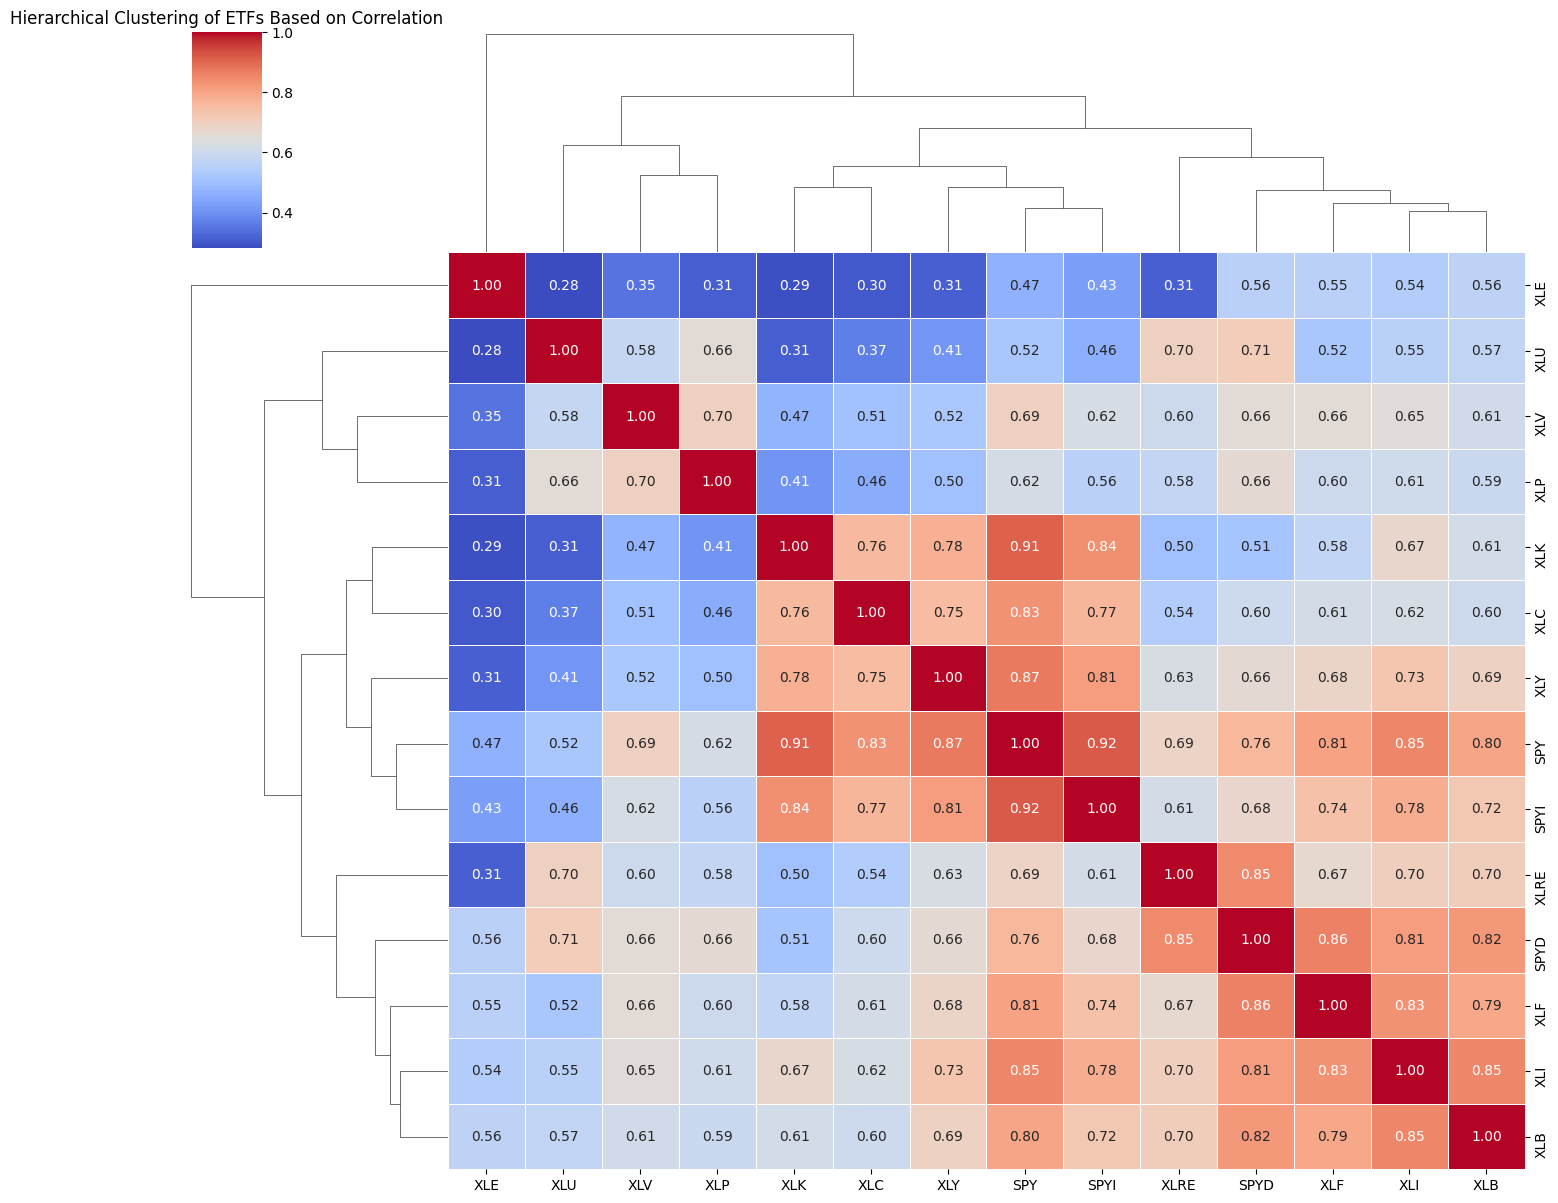

Max Sharpe Ratio Performance:
  Expected Return: 21.86%
  Volatility: 15.75%
  Sharpe Ratio: 1.26

Min Volatility Performance:
  Expected Return: 12.16%
  Volatility: 10.44%
  Sharpe Ratio: 0.97

Kelly Criterion Performance:
  Expected Return: 13.50%
  Volatility: 10.81%
  Sharpe Ratio: 1.25

Max Sharpe Ratio Weights:
  SPY: 0.00%
  XLK: 12.78%
  XLF: 0.00%
  XLV: 17.66%
  XLE: 0.00%
  XLY: 0.00%
  XLP: 0.00%
  XLI: 31.64%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 37.92%
  SPYD: 0.00%
  SPYI: 0.00%


Min Volatility Weights:
  SPY: 0.00%
  XLK: 0.00%
  XLF: 0.00%
  XLV: 15.66%
  XLE: 1.03%
  XLY: 0.00%
  XLP: 37.65%
  XLI: 0.00%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 0.00%
  SPYD: 0.00%
  SPYI: 45.65%


Kelly Criterion Weights:
  SPY: 0.00%
  XLK: 0.00%
  XLF: 0.00%
  XLV: 25.30%
  XLE: 0.00%
  XLY: 0.00%
  XLP: 19.29%
  XLI: 1.50%
  XLU: 0.00%
  XLB: 0.00%
  XLRE: 0.00%
  XLC: 4.42%
  SPYD: 0.00%
  SPYI: 49.48%


                   SPY         XLK        XLF         XLV   

In [9]:
import numpy as np
import pandas as pd
from pypfopt import risk_models, EfficientFrontier, expected_returns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns  # For static heatmaps and clustermaps
import plotly.express as px  # For interactive heatmaps

# Load historical price data and calculate returns
def load_price_data(etfs, interval):
    price_data = {}
    for etf in etfs:
        file_path = f'index_data/{interval}/{etf}_{interval}.csv'
        try:
            df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
            price_data[etf] = df['Close']
        except FileNotFoundError:
            print(f"File not found for {etf} at {file_path}. Ensure the file exists.")
            price_data[etf] = np.nan  # Assign NaN if file not found
    price_df = pd.DataFrame(price_data).dropna()  # Drop dates with missing data
    return price_df

# Calculate expected returns and covariance matrix
def calculate_returns_and_covariance(price_data):
    returns = price_data.pct_change().dropna()
    expected_returns_vals = returns.mean() * 252  # Annualize returns
    covariance_matrix = returns.cov() * 252  # Annualize covariance
    return expected_returns_vals, covariance_matrix, returns

# Load data and compute returns and covariance
price_data = load_price_data(etfs, '1d')
expected_returns_vals, covariance_matrix, returns = calculate_returns_and_covariance(price_data)

# Market equilibrium weights based on market caps
market_weights = market_caps / market_caps.sum()

# ============================
# Portfolio Optimization
# ============================

# Portfolio optimization for maximum Sharpe Ratio
ef_sharpe = EfficientFrontier(expected_returns_vals, covariance_matrix)
try:
    sharpe_weights = ef_sharpe.max_sharpe()
    cleaned_sharpe_weights = ef_sharpe.clean_weights()
    sharpe_performance = ef_sharpe.portfolio_performance()
except Exception as e:
    print(f"Error in Max Sharpe Ratio optimization: {e}")
    sharpe_weights = {}
    cleaned_sharpe_weights = {}
    sharpe_performance = {}

# Portfolio optimization for minimum volatility
ef_min_vol = EfficientFrontier(expected_returns_vals, covariance_matrix)
try:
    min_vol_weights = ef_min_vol.min_volatility()
    cleaned_min_vol_weights = ef_min_vol.clean_weights()
    min_vol_performance = ef_min_vol.portfolio_performance()
except Exception as e:
    print(f"Error in Min Volatility optimization: {e}")
    min_vol_weights = {}
    cleaned_min_vol_weights = {}
    min_vol_performance = {}

# Portfolio optimization using Kelly Criterion (Maximize expected log return)
def kelly_criterion(weights, expected_returns, covariance_matrix):
    # Prevent division by zero
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    if portfolio_variance == 0:
        return 1e10
    portfolio_return = np.dot(weights, expected_returns)
    return -portfolio_return / portfolio_variance  # Negative for minimization

# Initial guess
num_assets = len(etfs)
initial_weights = num_assets * [1. / num_assets,]

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0,1) for asset in range(num_assets))

# Optimization
kelly_result = minimize(
    kelly_criterion, 
    initial_weights, 
    args=(expected_returns_vals.values, covariance_matrix.values), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

if kelly_result.success:
    kelly_weights = kelly_result.x
    # Compute performance metrics
    kelly_return = np.dot(kelly_weights, expected_returns_vals.values)
    kelly_volatility = np.sqrt(np.dot(kelly_weights.T, np.dot(covariance_matrix.values, kelly_weights)))
    kelly_sharpe = kelly_return / kelly_volatility
    kelly_performance = (kelly_return, kelly_volatility, kelly_sharpe)
    # Clean weights for display
    cleaned_kelly_weights = {etf: weight for etf, weight in zip(etfs, kelly_weights)}
else:
    print("Kelly Criterion optimization failed.")
    kelly_weights = {}
    cleaned_kelly_weights = {}
    kelly_performance = {}


def plot_correlation_matrix(returns, etfs):
    correlation_matrix = returns.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                xticklabels=etfs, yticklabels=etfs, linewidths=0.5)
    plt.title('Correlation Matrix of ETFs')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot the correlation matrix
plot_correlation_matrix(returns, etfs)

# ============================
# Covariance Matrix Visualization
# ============================

def plot_covariance_matrix(covariance_matrix, etfs):
    plt.figure(figsize=(12, 10))
    sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='viridis', 
                xticklabels=etfs, yticklabels=etfs, linewidths=0.5)
    plt.title('Covariance Matrix of ETFs')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot the covariance matrix
plot_covariance_matrix(covariance_matrix, etfs)

# ============================
# Interactive Correlation Matrix Visualization
# ============================

def plot_interactive_correlation_matrix(returns, etfs):
    correlation_matrix = returns.corr()
    fig = px.imshow(
        correlation_matrix,
        x=etfs,
        y=etfs,
        color_continuous_scale='RdBu',
        zmin=-1,
        zmax=1,
        title='Interactive Correlation Matrix of ETFs',
        labels=dict(x="ETFs", y="ETFs", color="Correlation"),
        text_auto=True
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# Plot the interactive correlation matrix
plot_interactive_correlation_matrix(returns, etfs)

# ============================
# Hierarchical Clustering Visualization
# ============================

def plot_hierarchical_clustering(returns, etfs):
    correlation_matrix = returns.corr()
    sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                   linewidths=0.5, figsize=(14, 12))
    plt.title('Hierarchical Clustering of ETFs Based on Correlation')
    plt.show()

# Plot the hierarchical clustering clustermap
plot_hierarchical_clustering(returns, etfs)

# ============================
# Print Performance Metrics
# ============================

def print_performance(name, performance):
    if performance:
        print(f"{name} Performance:")
        print(f"  Expected Return: {performance[0]:.2%}")
        print(f"  Volatility: {performance[1]:.2%}")
        print(f"  Sharpe Ratio: {performance[2]:.2f}\n")
    else:
        print(f"{name} Performance: Not Available\n")

print_performance("Max Sharpe Ratio", sharpe_performance)
print_performance("Min Volatility", min_vol_performance)
print_performance("Kelly Criterion", kelly_performance)

# ============================
# Optional: Display Portfolio Weights
# ============================

def display_weights(name, weights):
    if weights:
        print(f"{name} Weights:")
        for etf, weight in weights.items():
            print(f"  {etf}: {weight:.2%}")
        print("\n")
    else:
        print(f"{name} Weights: Not Available\n")

display_weights("Max Sharpe Ratio", cleaned_sharpe_weights)
display_weights("Min Volatility", cleaned_min_vol_weights)
display_weights("Kelly Criterion", cleaned_kelly_weights)

# ============================
# Data Inspection (Optional)
# ============================

# Uncomment the following lines if you want to inspect the data
print(price_data.head())
print(expected_returns_vals)
print(covariance_matrix)
print(np.isnan(expected_returns_vals).any())  # Should return False
print(np.isnan(covariance_matrix).any())  # Should return False


# 4. Feature Engineering and Advanced Metrics

In [29]:
# ============================
# 4. Feature Engineering
# ============================

# 4.1. Quantitative Feature Calculation

# Define Sector Mapping (if not already defined)
sector_mapping = {
    'SPY': 'S&P 500',
    'XLK': 'Technology',
    'XLF': 'Financial',
    'XLV': 'Healthcare',
    'XLE': 'Energy',
    'XLY': 'Consumer Discretionary',
    'XLP': 'Consumer Staples',
    'XLI': 'Industrial',
    'XLU': 'Utilities',
    'XLB': 'Materials',
    'XLRE': 'Real Estate',
    'XLC': 'Communication Services',
    'SPYD': 'S&P 500 High Dividend',
    'SPYI': 'S&P 500 Infrastructure'
}

# Initialize a DataFrame to store all features
features_df = pd.DataFrame(index=returns.index)

# Parameters
window = 30  # Rolling window size in days
tail_percent = 0.05  # Tail percentage for Tail Ratio

# Calculate Features for Each ETF
for etf in etfs:
    # Compute Rolling Skewness
    features_df[f'{etf}_skewness'] = returns[etf].rolling(window).skew()
    
    # Compute Rolling Kurtosis
    features_df[f'{etf}_kurtosis'] = returns[etf].rolling(window).kurt()
    
    # Compute Rolling Sharpe Ratio (Assuming Risk-Free Rate = 0)
    rolling_mean = returns[etf].rolling(window).mean()
    rolling_std = returns[etf].rolling(window).std()
    features_df[f'{etf}_rolling_sharpe'] = rolling_mean / rolling_std
    
    # Compute Rolling Sortino Ratio (Assuming Target Return = 0)
    target = 0
    downside_returns = returns[etf].where(returns[etf] < target, 0)
    rolling_downside_std = downside_returns.rolling(window).std()
    features_df[f'{etf}_rolling_sortino'] = rolling_mean / rolling_downside_std
    
    # Compute Rolling Tail Ratio
    def tail_ratio(x):
        if len(x) < int(window * tail_percent * 2):
            return np.nan
        upper = x.quantile(1 - tail_percent)
        lower = x.quantile(tail_percent)
        upper_mean = x[x >= upper].mean()
        lower_mean = x[x <= lower].mean()
        if lower_mean == 0:
            return np.nan
        return upper_mean / abs(lower_mean)
    
    features_df[f'{etf}_tail_ratio'] = returns[etf].rolling(window).apply(tail_ratio, raw=False)
    
    # Compute Kelly Ratio (Mean Return / Variance)
    mean_return = returns[etf].rolling(window).mean()
    variance = returns[etf].rolling(window).var()
    features_df[f'{etf}_kelly_ratio'] = mean_return / variance

# Drop initial rows with NaN values due to rolling calculations
features_df.dropna(inplace=True)

# Aggregation: Monthly and Weekly
# Resample to monthly frequency
features_monthly = features_df.resample('M').mean()

# Resample to weekly frequency
features_weekly = features_df.resample('W').mean()


# 5. Seasonality Analysis

In [37]:
# ============================
# 5. Seasonality Analysis
# ============================

# Import additional libraries for statistical testing
from scipy.stats import f_oneway
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 5.1. Identifying Seasonal Patterns

def perform_anova(returns, period='month'):
    """
    Perform ANOVA to test for significant differences in ETF returns across different periods.

    Parameters:
    - returns (pd.DataFrame): DataFrame containing daily returns of ETFs.
    - period (str): 'month' or 'week' to specify the grouping period.

    Returns:
    - results (dict): Dictionary containing p-values for each ETF.
    """
    results = {}
    if period == 'month':
        grouped = returns.groupby(returns.index.month)
    elif period == 'week':
        grouped = returns.groupby(returns.index.isocalendar().week)
    else:
        raise ValueError("Period must be either 'month' or 'week'.")
    
    for etf in returns.columns:
        groups = [group[etf].dropna() for name, group in grouped]
        # Perform one-way ANOVA
        try:
            stat, p = f_oneway(*groups)
            results[etf] = p
        except Exception as e:
            print(f"ANOVA failed for {etf} with error: {e}")
            results[etf] = np.nan
    return results

# 5.2. Monthly and Weekly Performance

# Calculate average monthly returns for each ETF
average_monthly_returns = returns.resample('M').mean()
average_monthly_returns['Month'] = average_monthly_returns.index.month
monthly_avg = average_monthly_returns.groupby('Month').mean()

# Calculate average weekly returns for each ETF
average_weekly_returns = returns.resample('W').mean()
average_weekly_returns['Week'] = average_weekly_returns.index.isocalendar().week
weekly_avg = average_weekly_returns.groupby('Week').mean()

# Create a mapping from month numbers to month names for better readability
import calendar
month_names = {i: calendar.month_name[i] for i in range(1, 13)}

# 5.3. Visualization Techniques

# Function to plot interactive heatmap of average monthly returns
def plot_interactive_monthly_heatmap(monthly_avg, etfs):
    monthly_avg_pivot = monthly_avg.copy()
    monthly_avg_pivot.index = monthly_avg_pivot.index.map(lambda x: month_names.get(x, x))
    
    fig = px.imshow(
        monthly_avg_pivot.T,
        labels=dict(x="Month", y="ETFs", color="Average Return"),
        x=monthly_avg_pivot.index,
        y=etfs,
        color_continuous_scale='RdBu',
        title='Interactive Heatmap of Average Monthly Returns'
    )
    fig.update_xaxes(side="top")
    fig.update_layout(
        xaxis_title='Month',
        yaxis_title='ETFs',
        title={'x': 0.5}
    )
    fig.show()

# Function to plot interactive heatmap of average weekly returns
def plot_interactive_weekly_heatmap(weekly_avg, etfs):
    # Ensure week numbers are integers
    weekly_avg_pivot = weekly_avg.copy()
    weekly_avg_pivot.index = weekly_avg_pivot.index.map(int)
    
    fig = px.imshow(
        weekly_avg_pivot.T,
        labels=dict(x="Week Number", y="ETFs", color="Average Return"),
        x=weekly_avg_pivot.index,
        y=etfs,
        color_continuous_scale='RdBu',
        title='Interactive Heatmap of Average Weekly Returns'
    )
    fig.update_xaxes(side="top")
    fig.update_layout(
        xaxis_title='Week Number',
        yaxis_title='ETFs',
        title={'x': 0.5}
    )
    fig.show()

# Function to plot interactive line plot of average monthly returns
def plot_interactive_monthly_line_plot(monthly_avg, etfs):
    fig = go.Figure()
    for etf in etfs:
        fig.add_trace(go.Scatter(
            x=[month_names[m] for m in monthly_avg.index],
            y=monthly_avg[etf],
            mode='lines+markers',
            name=etf
        ))
    fig.update_layout(
        title='Interactive Line Plot of Average Monthly Returns',
        xaxis_title='Month',
        yaxis_title='Average Return',
        hovermode='closest'
    )
    fig.show()

# Function to plot interactive line plot of average weekly returns
def plot_interactive_weekly_line_plot(weekly_avg, etfs):
    fig = go.Figure()
    for etf in etfs:
        fig.add_trace(go.Scatter(
            x=weekly_avg.index,
            y=weekly_avg[etf],
            mode='lines+markers',
            name=etf
        ))
    fig.update_layout(
        title='Interactive Line Plot of Average Weekly Returns',
        xaxis_title='Week Number',
        yaxis_title='Average Return',
        hovermode='closest'
    )
    fig.show()

# Interactive Seasonality Visualization Function
def plot_interactive_seasonality(monthly_avg, weekly_avg, etfs):
    # Interactive Monthly Heatmap
    plot_interactive_monthly_heatmap(monthly_avg, etfs)
    
    # Interactive Weekly Heatmap
    plot_interactive_weekly_heatmap(weekly_avg, etfs)
    
    # Interactive Line Plot for Monthly Returns
    plot_interactive_monthly_line_plot(monthly_avg, etfs)
    
    # Interactive Line Plot for Weekly Returns
    plot_interactive_weekly_line_plot(weekly_avg, etfs)

# ============================
# Execute Seasonality Analysis
# ============================

# 5.1. Perform ANOVA to test for seasonality significance
# ANOVA (Analysis of Variance) is a statistical method used to test if there are significant differences
# between the means of two or more groups. In this context, it can be used to determine if the average
# returns for different months or weeks are significantly different from each other, indicating seasonality.

# Ensure 'returns' DataFrame contains only numeric values
returns_numeric = returns.select_dtypes(include=[np.number])

# Perform ANOVA for monthly returns
anova_month = sm.stats.anova_lm(ols('returns.iloc[:,0] ~ C(month)', data=returns_numeric.assign(month=returns_numeric.index.month.astype(int))).fit())
print('ANOVA for Monthly Returns:')
print(anova_month)

# Interpret ANOVA results for monthly returns
if anova_month['PR(>F)'].iloc[0] < 0.05:
    print("There is a significant difference in monthly returns.")
else:
    print("No significant difference in monthly returns.")

# Perform ANOVA for weekly returns
anova_week = sm.stats.anova_lm(ols('returns.iloc[:,0] ~ C(week)', data=returns_numeric.assign(week=returns_numeric.index.isocalendar().week.astype(int))).fit())
print('ANOVA for Weekly Returns:')
print(anova_week)

# Interpret ANOVA results for weekly returns
if anova_week['PR(>F)'].iloc[0] < 0.05:
    print("There is a significant difference in weekly returns.")
else:
    print("No significant difference in weekly returns.")

# 5.2. Plotting Average Monthly and Weekly Returns

# Plot Interactive Heatmaps and Line Plots
plot_interactive_seasonality(monthly_avg, weekly_avg, etfs)


ANOVA for Monthly Returns:
             df    sum_sq   mean_sq         F    PR(>F)
C(month)   11.0  0.001339  0.000122  1.279179  0.232933
Residual  501.0  0.047674  0.000095       NaN       NaN
No significant difference in monthly returns.
ANOVA for Weekly Returns:
             df    sum_sq   mean_sq         F    PR(>F)
C(week)    51.0  0.003507  0.000069  0.696683  0.944324
Residual  461.0  0.045506  0.000099       NaN       NaN
No significant difference in weekly returns.


# 6. Risk Analysis

In [58]:
# ============================
# 6. Risk Analysis
# ============================

import numpy as np
import pandas as pd
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
from pypfopt import risk_models, EfficientFrontier, expected_returns

# Ensure that 'returns' DataFrame is already defined from previous sections
# If not, uncomment and run the relevant data loading and return calculation sections

# 6.1. Value at Risk (VaR)

def calculate_var(returns, confidence_level=0.95, method='historical'):
    """
    Calculate Value at Risk (VaR) for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - confidence_level (float): Confidence level for VaR (e.g., 0.95 for 95%).
    - method (str): 'historical' or 'parametric'.
    
    Returns:
    - var_df (pd.DataFrame): DataFrame containing VaR values for each ETF.
    """
    var_df = pd.DataFrame(index=returns.columns, columns=['VaR'])
    
    for etf in returns.columns:
        if method == 'historical':
            var = returns[etf].quantile(1 - confidence_level)
        elif method == 'parametric':
            mu = returns[etf].mean()
            sigma = returns[etf].std()
            var = norm.ppf(1 - confidence_level, mu, sigma)
        else:
            raise ValueError("Method must be 'historical' or 'parametric'.")
        var_df.loc[etf, 'VaR'] = var
    
    return var_df.astype(float)

# 6.2. Conditional Value at Risk (CVaR)

def calculate_cvar(returns, confidence_level=0.95, method='historical'):
    """
    Calculate Conditional Value at Risk (CVaR) for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - confidence_level (float): Confidence level for CVaR (e.g., 0.95 for 95%).
    - method (str): Currently supports 'historical'.
    
    Returns:
    - cvar_df (pd.DataFrame): DataFrame containing CVaR values for each ETF.
    """
    if method != 'historical':
        raise NotImplementedError("Currently only 'historical' method is implemented for CVaR.")
    
    cvar_df = pd.DataFrame(index=returns.columns, columns=['CVaR'])
    
    for etf in returns.columns:
        var = returns[etf].quantile(1 - confidence_level)
        cvar = returns[etf][returns[etf] <= var].mean()
        cvar_df.loc[etf, 'CVaR'] = cvar
    
    return cvar_df.astype(float)

# 6.3. Maximum Drawdown

def calculate_max_drawdown(returns):
    """
    Calculate Maximum Drawdown for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    
    Returns:
    - mdd_df (pd.DataFrame): DataFrame containing Maximum Drawdown for each ETF.
    """
    mdd_df = pd.DataFrame(index=returns.columns, columns=['Max_Drawdown'])
    
    for etf in returns.columns:
        cumulative = (1 + returns[etf]).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = drawdown.min()
        mdd_df.loc[etf, 'Max_Drawdown'] = max_drawdown
    
    return mdd_df.astype(float)

# 6.4. Beta and Alpha

def calculate_beta_alpha(returns, benchmark_returns):
    """
    Calculate Beta and Alpha for each ETF relative to a benchmark.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns for ETFs.
    - benchmark_returns (pd.Series): Series of daily returns for the benchmark.
    
    Returns:
    - beta_alpha_df (pd.DataFrame): DataFrame containing Beta and Alpha for each ETF.
    """
    beta_alpha_df = pd.DataFrame(index=returns.columns, columns=['Beta', 'Alpha'])
    
    for etf in returns.columns:
        # Align data
        aligned_returns = pd.concat([returns[etf], benchmark_returns], axis=1).dropna()
        etf_returns = aligned_returns.iloc[:,0]
        bench_returns = aligned_returns.iloc[:,1]
        
        # Calculate covariance and variance
        covariance = np.cov(etf_returns, bench_returns)[0,1]
        variance = np.var(bench_returns)
        
        beta = covariance / variance
        alpha = etf_returns.mean() - beta * bench_returns.mean()
        
        beta_alpha_df.loc[etf, 'Beta'] = beta
        beta_alpha_df.loc[etf, 'Alpha'] = alpha
    
    return beta_alpha_df.astype(float)

# 6.5. Risk Contribution per Asset

def calculate_risk_contribution(weights, covariance_matrix):
    """
    Calculate risk contribution of each asset in the portfolio.
    
    Parameters:
    - weights (dict or pd.Series): Portfolio weights.
    - covariance_matrix (pd.DataFrame): Covariance matrix of asset returns.
    
    Returns:
    - rc_df (pd.DataFrame): DataFrame containing risk contributions of each asset.
    """
    weights = np.array(list(weights.values()))
    cov = covariance_matrix.values
    portfolio_variance = weights.T @ cov @ weights
    marginal_contrib = cov @ weights
    risk_contrib = weights * marginal_contrib / portfolio_variance
    rc_df = pd.DataFrame(risk_contrib, index=covariance_matrix.columns, columns=['Risk_Contribution'])
    return rc_df

# 6.6. Visualization of Risk Metrics

def plot_risk_metrics(var_df, cvar_df, mdd_df, beta_alpha_df, rc_df):
    """
    Plot interactive visualizations for risk metrics using Plotly.
    
    Parameters:
    - var_df (pd.DataFrame): VaR values.
    - cvar_df (pd.DataFrame): CVaR values.
    - mdd_df (pd.DataFrame): Maximum Drawdown values.
    - beta_alpha_df (pd.DataFrame): Beta and Alpha values.
    - rc_df (pd.DataFrame): Risk Contribution per asset.
    """
    # VaR Bar Chart
    fig_var = go.Figure()
    fig_var.add_trace(go.Bar(x=var_df.index, y=var_df['VaR'], marker_color='#1f77b4'))
    fig_var.update_layout(title='Value at Risk (VaR) per ETF',
                          xaxis_title='ETF',
                          yaxis_title='VaR (95%)',
                          plot_bgcolor='rgba(0,0,0,0)')
    fig_var.show()
    
    # CVaR Bar Chart
    fig_cvar = go.Figure()
    fig_cvar.add_trace(go.Bar(x=cvar_df.index, y=cvar_df['CVaR'], marker_color='#ff7f0e'))
    fig_cvar.update_layout(title='Conditional Value at Risk (CVaR) per ETF',
                           xaxis_title='ETF',
                           yaxis_title='CVaR (95%)',
                           plot_bgcolor='rgba(0,0,0,0)')
    fig_cvar.show()
    
    # Maximum Drawdown Bar Chart
    fig_mdd = go.Figure()
    fig_mdd.add_trace(go.Bar(x=mdd_df.index, y=mdd_df['Max_Drawdown'], marker_color='#2ca02c'))
    fig_mdd.update_layout(title='Maximum Drawdown per ETF',
                          xaxis_title='ETF',
                          yaxis_title='Max Drawdown',
                          plot_bgcolor='rgba(0,0,0,0)')
    fig_mdd.show()
    
    # Beta and Alpha Scatter Plot
    fig_beta_alpha = go.Figure()
    fig_beta_alpha.add_trace(go.Scatter(x=beta_alpha_df['Beta'], y=beta_alpha_df['Alpha'],
                                        mode='markers+text',
                                        text=beta_alpha_df.index,
                                        textposition='top center',
                                        marker=dict(color='#d62728', size=10)))
    fig_beta_alpha.update_layout(title='Beta vs. Alpha for Each ETF',
                                 xaxis_title='Beta',
                                 yaxis_title='Alpha',
                                 plot_bgcolor='rgba(0,0,0,0)')
    fig_beta_alpha.show()
    
    # Risk Contribution Pie Chart
    rc = rc_df['Risk_Contribution']
    fig_rc = go.Figure(data=[go.Pie(labels=rc_df.index, values=rc, hole=0.4)])
    fig_rc.update_layout(title='Risk Contribution per ETF',
                         plot_bgcolor='rgba(0,0,0,0)')
    fig_rc.show()

# ============================
# Execute Risk Analysis
# ============================

# 6.1. Calculate Value at Risk (VaR)
var_historical = calculate_var(returns, confidence_level=0.95, method='historical')
var_parametric = calculate_var(returns, confidence_level=0.95, method='parametric')

# 6.2. Calculate Conditional Value at Risk (CVaR)
cvar_historical = calculate_cvar(returns, confidence_level=0.95, method='historical')

# 6.3. Calculate Maximum Drawdown
max_drawdown = calculate_max_drawdown(returns)

# 6.4. Calculate Beta and Alpha
# Define Benchmark (e.g., S&P 500)
# Assuming 'SPY' is the benchmark ETF
benchmark_returns = returns['SPY']

beta_alpha = calculate_beta_alpha(returns, benchmark_returns)

# 6.5. Calculate Risk Contribution per Asset
# Assuming you have portfolio weights from one of the optimized portfolios, e.g., Max Sharpe Ratio
portfolio_weights = cleaned_sharpe_weights  # Replace with desired portfolio
risk_contribution = calculate_risk_contribution(portfolio_weights, covariance_matrix)

# 6.6. Visualization of Risk Metrics
plot_risk_metrics(var_historical, cvar_historical, max_drawdown, beta_alpha, risk_contribution)


In [60]:
# ============================
# 6. Risk Analysis on a Seasonality Basis
# ============================

import numpy as np
import pandas as pd
from scipy.stats import norm, linregress
import plotly.graph_objects as go
import plotly.express as px

# Ensure that 'returns', 'benchmark_returns', and 'cleaned_sharpe_weights' are already defined
# from previous sections.

# 6.1. Seasonal Value at Risk (VaR)

def calculate_seasonal_var(returns, confidence_level=0.95, method='historical', period='M'):
    """
    Calculate seasonal Value at Risk (VaR) for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - confidence_level (float): Confidence level for VaR (e.g., 0.95 for 95%).
    - method (str): 'historical' or 'parametric'.
    - period (str): Resampling period ('M' for monthly, 'W' for weekly).
    
    Returns:
    - var_seasonal_df (pd.DataFrame): DataFrame containing VaR values for each ETF per season.
    """
    var_seasonal = {}
    
    # Resample returns to the specified period
    if period == 'M':
        grouped = returns.resample('M')
    elif period == 'W':
        grouped = returns.resample('W')
    else:
        raise ValueError("Period must be 'M' for monthly or 'W' for weekly.")
    
    for etf in returns.columns:
        var_values = []
        seasons = []
        for name, group in grouped:
            if group.empty:
                var = np.nan
            else:
                if method == 'historical':
                    var = group[etf].quantile(1 - confidence_level)
                elif method == 'parametric':
                    mu = group[etf].mean()
                    sigma = group[etf].std()
                    var = norm.ppf(1 - confidence_level, mu, sigma)
                else:
                    raise ValueError("Method must be 'historical' or 'parametric'.")
            var_values.append(var)
            seasons.append(name)
        var_seasonal[etf] = var_values
    
    var_seasonal_df = pd.DataFrame(var_seasonal, index=seasons)
    var_seasonal_df = var_seasonal_df.reindex(index=sorted(var_seasonal_df.index), columns=sorted(var_seasonal_df.columns))
    return var_seasonal_df

# 6.2. Seasonal Conditional Value at Risk (CVaR)

def calculate_seasonal_cvar(returns, confidence_level=0.95, period='M'):
    """
    Calculate seasonal Conditional Value at Risk (CVaR) for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - confidence_level (float): Confidence level for CVaR (e.g., 0.95 for 95%).
    - period (str): Resampling period ('M' for monthly, 'W' for weekly).
    
    Returns:
    - cvar_seasonal_df (pd.DataFrame): DataFrame containing CVaR values for each ETF per season.
    """
    cvar_seasonal = {}
    
    # Resample returns to the specified period
    if period == 'M':
        grouped = returns.resample('M')
    elif period == 'W':
        grouped = returns.resample('W')
    else:
        raise ValueError("Period must be 'M' for monthly or 'W' for weekly.")
    
    for etf in returns.columns:
        cvar_values = []
        seasons = []
        for name, group in grouped:
            if group.empty:
                cvar = np.nan
            else:
                var = group[etf].quantile(1 - confidence_level)
                losses = group[etf][group[etf] <= var]
                if losses.empty:
                    cvar = np.nan
                else:
                    cvar = losses.mean()
            cvar_values.append(cvar)
            seasons.append(name)
        cvar_seasonal[etf] = cvar_values
    
    cvar_seasonal_df = pd.DataFrame(cvar_seasonal, index=seasons)
    cvar_seasonal_df = cvar_seasonal_df.reindex(index=sorted(cvar_seasonal_df.index), columns=sorted(cvar_seasonal_df.columns))
    return cvar_seasonal_df

# 6.3. Seasonal Maximum Drawdown
def calculate_seasonal_max_drawdown(returns, period='M'):
    """
    Calculate seasonal Maximum Drawdown for each ETF.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - period (str): Resampling period ('M' for monthly, 'W' for weekly).
    
    Returns:
    - mdd_seasonal_df (pd.DataFrame): DataFrame containing Maximum Drawdown for each ETF per season.
    """
    mdd_seasonal = {}
    
    # Resample returns to the specified period
    if period == 'M':
        grouped = returns.resample('M')
    elif period == 'W':
        grouped = returns.resample('W')
    else:
        raise ValueError("Period must be 'M' for monthly or 'W' for weekly.")
    
    for etf in returns.columns:
        mdd_values = []
        seasons = []
        for name, group in grouped:
            if group.empty:
                mdd = np.nan
            else:
                cumulative = (1 + group[etf]).cumprod()
                peak = cumulative.cummax()
                drawdown = (cumulative - peak) / peak
                mdd = drawdown.min()
            mdd_values.append(mdd)
            seasons.append(name)
        mdd_seasonal[etf] = mdd_values
    
    mdd_seasonal_df = pd.DataFrame(mdd_seasonal, index=seasons)
    mdd_seasonal_df = mdd_seasonal_df.reindex(index=sorted(mdd_seasonal_df.index), columns=sorted(mdd_seasonal_df.columns))
    return mdd_seasonal_df


# 6.4. Seasonal Beta and Alpha

def calculate_seasonal_beta_alpha(returns, benchmark_returns, period='M'):
    """
    Calculate seasonal Beta and Alpha for each ETF relative to a benchmark.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns for ETFs.
    - benchmark_returns (pd.Series): Series of daily returns for the benchmark.
    - period (str): Resampling period ('M' for monthly, 'W' for weekly).
    
    Returns:
    - beta_alpha_seasonal_df (pd.DataFrame): DataFrame containing Beta and Alpha for each ETF per season.
    """
    beta_alpha_seasonal = {}
    
    # Resample returns and benchmark to the specified period
    if period == 'M':
        grouped = returns.resample('M')
        benchmark_grouped = benchmark_returns.resample('M')
    elif period == 'W':
        grouped = returns.resample('W')
        benchmark_grouped = benchmark_returns.resample('W')
    else:
        raise ValueError("Period must be 'M' for monthly or 'W' for weekly.")
    
    for etf in returns.columns:
        beta_values = []
        alpha_values = []
        seasons = []
        for name, group in grouped:
            bench_group = benchmark_grouped.get_group(name) if name in benchmark_grouped.groups else pd.Series()
            combined = pd.concat([group[etf], bench_group], axis=1).dropna()
            etf_returns = combined.iloc[:,0]
            bench_returns = combined.iloc[:,1]
            if len(combined) < 2:
                beta = np.nan
                alpha = np.nan
            else:
                slope, intercept, r_value, p_value, std_err = linregress(bench_returns, etf_returns)
                beta = slope
                alpha = intercept
            beta_values.append(beta)
            alpha_values.append(alpha)
            seasons.append(name)
        beta_alpha_seasonal[etf] = {'Beta': beta_values, 'Alpha': alpha_values}
    
    # Create DataFrame
    beta_alpha_seasonal_df = {}
    for etf in returns.columns:
        beta_alpha_seasonal_df[f'{etf}_Beta'] = beta_alpha_seasonal[etf]['Beta']
        beta_alpha_seasonal_df[f'{etf}_Alpha'] = beta_alpha_seasonal[etf]['Alpha']
    
    beta_alpha_seasonal_df = pd.DataFrame(beta_alpha_seasonal_df, index=seasons)
    beta_alpha_seasonal_df = beta_alpha_seasonal_df.reindex(index=sorted(beta_alpha_seasonal_df.index), columns=sorted(beta_alpha_seasonal_df.columns))
    return beta_alpha_seasonal_df

# 6.5. Visualization of Seasonal Risk Metrics

def plot_seasonal_risk_metrics(var_seasonal_df, cvar_seasonal_df, mdd_seasonal_df, beta_alpha_seasonal_df, period='M'):
    """
    Plot interactive visualizations for seasonal risk metrics using Plotly.
    
    Parameters:
    - var_seasonal_df (pd.DataFrame): VaR values per ETF per season.
    - cvar_seasonal_df (pd.DataFrame): CVaR values per ETF per season.
    - mdd_seasonal_df (pd.DataFrame): Maximum Drawdown per ETF per season.
    - beta_alpha_seasonal_df (pd.DataFrame): Beta and Alpha per ETF per season.
    - period (str): 'M' for monthly or 'W' for weekly.
    """
    # Define season labels
    if period == 'M':
        import calendar
        season_labels = [calendar.month_name[m] for m in var_seasonal_df.index.month]
        season_labels = sorted(season_labels, key=lambda x: list(calendar.month_name).index(x))
    elif period == 'W':
        season_labels = [f"Week {w}" for w in range(1, 53)]
    else:
        season_labels = sorted(var_seasonal_df.index.astype(str))
    
    # VaR Heatmap
    fig_var = go.Figure(data=go.Heatmap(
        z=var_seasonal_df.T.values,
        x=season_labels,
        y=var_seasonal_df.columns,
        colorscale='RdBu',
        zmin=var_seasonal_df.values.min(),
        zmax=var_seasonal_df.values.max()
    ))
    fig_var.update_layout(
        title=f'Interactive Heatmap of Seasonal VaR ({int(confidence_level*100)}%)',
        xaxis_title='Season',
        yaxis_title='ETFs',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig_var.show()
    
    # CVaR Heatmap
    fig_cvar = go.Figure(data=go.Heatmap(
        z=cvar_seasonal_df.T.values,
        x=season_labels,
        y=cvar_seasonal_df.columns,
        colorscale='RdBu',
        zmin=cvar_seasonal_df.values.min(),
        zmax=cvar_seasonal_df.values.max()
    ))
    fig_cvar.update_layout(
        title=f'Interactive Heatmap of Seasonal CVaR ({int(confidence_level*100)}%)',
        xaxis_title='Season',
        yaxis_title='ETFs',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig_cvar.show()
    
    # Maximum Drawdown Heatmap
    fig_mdd = go.Figure(data=go.Heatmap(
        z=mdd_seasonal_df.T.values,
        x=season_labels,
        y=mdd_seasonal_df.columns,
        colorscale='YlGnBu',
        zmin=mdd_seasonal_df.values.min(),
        zmax=mdd_seasonal_df.values.max()
    ))
    fig_mdd.update_layout(
        title='Interactive Heatmap of Seasonal Maximum Drawdown',
        xaxis_title='Season',
        yaxis_title='ETFs',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig_mdd.show()
    
    # Beta Heatmap
    beta_cols = [col for col in beta_alpha_seasonal_df.columns if 'Beta' in col]
    beta_df = beta_alpha_seasonal_df[beta_cols]
    fig_beta = go.Figure(data=go.Heatmap(
        z=beta_df.T.values,
        x=season_labels,
        y=beta_df.columns,
        colorscale='Viridis',
        zmin=beta_df.values.min(),
        zmax=beta_df.values.max()
    ))
    fig_beta.update_layout(
        title='Interactive Heatmap of Seasonal Beta',
        xaxis_title='Season',
        yaxis_title='ETFs',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig_beta.show()
    
    # Alpha Heatmap
    alpha_cols = [col for col in beta_alpha_seasonal_df.columns if 'Alpha' in col]
    alpha_df = beta_alpha_seasonal_df[alpha_cols]
    fig_alpha = go.Figure(data=go.Heatmap(
        z=alpha_df.T.values,
        x=season_labels,
        y=alpha_df.columns,
        colorscale='Viridis',
        zmin=alpha_df.values.min(),
        zmax=alpha_df.values.max()
    ))
    fig_alpha.update_layout(
        title='Interactive Heatmap of Seasonal Alpha',
        xaxis_title='Season',
        yaxis_title='ETFs',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig_alpha.show()

    # Line Plots for Each Metric
    # VaR Line Plot
    for etf in var_seasonal_df.columns:
        fig = px.line(
            x=season_labels[:len(var_seasonal_df[etf])],
            y=var_seasonal_df[etf],
            labels={'x': 'Season', 'y': 'VaR'},
            title=f'VaR Over Seasons for {etf}',
            markers=True
        )
        fig.update_traces(mode='lines+markers')
        fig.show()
    
    # CVaR Line Plot
    for etf in cvar_seasonal_df.columns:
        fig = px.line(
            x=season_labels[:len(cvar_seasonal_df[etf])],
            y=cvar_seasonal_df[etf],
            labels={'x': 'Season', 'y': 'CVaR'},
            title=f'CVaR Over Seasons for {etf}',
            markers=True
        )
        fig.update_traces(mode='lines+markers')
        fig.show()
    
    # Maximum Drawdown Line Plot
    for etf in mdd_seasonal_df.columns:
        fig = px.line(
            x=season_labels[:len(mdd_seasonal_df[etf])],
            y=mdd_seasonal_df[etf],
            labels={'x': 'Season', 'y': 'Max Drawdown'},
            title=f'Maximum Drawdown Over Seasons for {etf}',
            markers=True
        )
        fig.update_traces(mode='lines+markers')
        fig.show()
    
    # Beta Line Plot
    for etf in beta_df.columns:
        fig = px.line(
            x=season_labels[:len(beta_df[etf])],
            y=beta_df[etf],
            labels={'x': 'Season', 'y': 'Beta'},
            title=f'Beta Over Seasons for {etf}',
            markers=True
        )
        fig.update_traces(mode='lines+markers')
        fig.show()
    
    # Alpha Line Plot
    for etf in alpha_df.columns:
        fig = px.line(
            x=season_labels[:len(alpha_df[etf])],
            y=alpha_df[etf],
            labels={'x': 'Season', 'y': 'Alpha'},
            title=f'Alpha Over Seasons for {etf}',
            markers=True
        )
        fig.update_traces(mode='lines+markers')
        fig.show()


# ============================
# Execute Seasonal Risk Analysis
# ============================

# Define Confidence Level for VaR and CVaR
confidence_level = 0.95

# Define Resampling Period ('M' for Monthly, 'W' for Weekly)
resample_period = 'M'  # Change to 'W' for Weekly analysis if desired

# 6.1. Calculate Seasonal VaR
seasonal_var_historical = calculate_seasonal_var(returns, confidence_level=confidence_level, method='historical', period=resample_period)
seasonal_var_parametric = calculate_seasonal_var(returns, confidence_level=confidence_level, method='parametric', period=resample_period)


# 6.2. Calculate Seasonal CVaR
seasonal_cvar_historical = calculate_seasonal_cvar(returns, confidence_level=confidence_level, period=resample_period)

# 6.3. Calculate Seasonal Maximum Drawdown
seasonal_max_drawdown = calculate_seasonal_max_drawdown(returns, period=resample_period)

# 6.4. Calculate Seasonal Beta and Alpha
# Assuming 'SPY' is the benchmark
benchmark_returns = returns['SPY']
seasonal_beta_alpha = calculate_seasonal_beta_alpha(returns, benchmark_returns, period=resample_period)

# 6.5. Visualization of Seasonal Risk Metrics

plot_seasonal_risk_metrics(seasonal_var_historical, seasonal_cvar_historical, seasonal_max_drawdown, seasonal_beta_alpha, period='M')

plot_seasonal_risk_metrics(seasonal_var_historical, seasonal_cvar_historical, seasonal_max_drawdown, seasonal_beta_alpha, period='W')

# 7. Performance and Return Comparison

# 8. Summary Table

# 9. Conclusion and Insights